In [121]:
import simpy
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
from math import ceil
from concurrent.futures import ThreadPoolExecutor

In [78]:
def seed_all(seed=42):
    np.random.seed(seed)

In [122]:
class MMN:
    def __init__(self, lamb: float, mu: float, num_servers_arr: np.array, T: int, queue_monitor_freq: float = None):
        """
        lamb: the arrival rate of the number of jobs into the system as a whole.
        mu: the capacity of each of the N servers.
        num_servers_arr: array of different number of servers to run simulation for, 
            i.e. [1,2] denotes simulation is run with the same samples when there are 1 servers and 2 servers.
        T: the time horizon to run the simulation for.
        queue_monitor_freq: the frequency to monitor the queue for every time unit.
        """
        self.lamb = lamb
        self.mu = mu
        self.num_servers_arr = num_servers_arr
        self.T = T
        self.rho = lamb / (num_servers_arr * mu)  # load of the system
        self.batch_sample_size = ceil(self.lamb*self.T*10)
        self.num_diff_N = len(num_servers_arr)

        # SimPy environment and resources
        self.env = simpy.Environment()
        self.servers_diff_N = [simpy.Resource(self.env, capacity=N) for N in num_servers_arr]

        # Statistics
        self.waiting_times = [[] for _ in range(self.num_diff_N)]
        self.system_times = [[] for _ in range(self.num_diff_N)]
        if queue_monitor_freq:
            self.queue_monitor_interval = 1/queue_monitor_freq
            self.num_queue_monitor = T*queue_monitor_freq
            self.queue_lengths = np.zeros((self.num_diff_N, self.num_queue_monitor), dtype=np.uint32)

    def job_arrival(self):
        """Generate job arrivals."""
        while True:
            job_arrival_times = expon.rvs(scale=1/self.lamb, size=self.batch_sample_size)
            service_durations = expon.rvs(scale=1/self.mu, size=self.batch_sample_size)
            for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                yield self.env.timeout(job_arrival_time)
                for Ns_idx in range(self.num_diff_N):
                    self.env.process(self.job_process(service_duration, Ns_idx))

    def job_process(self, service_duration, Ns_idx):
        """Process a single job."""
        arrival_time = self.env.now
        
        with self.servers_diff_N[Ns_idx].request() as request:
            yield request

            self.waiting_times[Ns_idx].append(self.env.now - arrival_time)

            yield self.env.timeout(service_duration)
            
            self.system_times[Ns_idx].append(self.env.now - arrival_time)

    def monitor_queue(self):
        """Monitor queue length."""
        for t in range(self.num_queue_monitor):
            for Ns_idx in range(self.num_diff_N):
                self.queue_lengths[Ns_idx, t] = len(self.servers_diff_N[Ns_idx].queue)
            yield self.env.timeout(self.queue_monitor_interval)

    def run_simulation(self):
        """Run the simulation."""
        self.env.process(self.job_arrival())
        self.env.process(self.monitor_queue())
        self.env.run(until=self.T)

        return {
            'avg_queue_length': np.mean(self.queue_lengths, axis=1),
            'avg_waiting_time': [np.mean(wt) for wt in self.waiting_times],
            'avg_system_time': [np.mean(st) for st in self.system_times],
            'queue_lengths': self.queue_lengths,
            'waiting_times': self.waiting_times,
            'system_times': self.system_times
        }

In [135]:
def run_multiple_simulations(num_runs, lamb, mu, num_servers_arr, T, queue_monitor_freq=1):
    """Run multiple simulations and average the results."""

    seed_all()

    num_diff_N = len(num_servers_arr)

    results = {
        'avg_queue_length': np.zeros(num_diff_N),
        'avg_waiting_time': np.zeros(num_diff_N),
        'avg_system_time': np.zeros(num_diff_N),
        'queue_lengths': np.zeros((num_diff_N, queue_monitor_freq*T)),
        'waiting_times': [[] for _ in range(num_diff_N)],
        'system_times': [[] for _ in range(num_diff_N)]
    }

    MMNs = [MMN(lamb=lamb, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, queue_monitor_freq=queue_monitor_freq) for i in range(num_runs)]
    results_diff_runs = None

    with ThreadPoolExecutor() as ex:
        results_diff_runs = \
            list(ex.map(lambda i: MMNs[i].run_simulation(), range(num_runs)))

    for sim_res in results_diff_runs:
        for key in results:
            if key.startswith('avg_') or key == 'queue_lengths':
                results[key] += sim_res[key]
            else:
                for i in range(len(num_servers_arr)):
                    results[key][i].extend(sim_res[key][i])

    for key in results:
        if key.startswith('avg_') or key == 'queue_lengths':
            results[key] /= num_runs

    return results

In [118]:
def plot_statistics(results, num_servers_arr, lamb, mu, T, num_runs, n_bins=50, edge_color=None, edge_width=0.05):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Queue Length Plot
    for i in range(len(num_servers_arr)):
        ax1.plot(results['queue_lengths'][i], label=f'Servers: {num_servers_arr[i]}')
    ax1.set_title(f'Queue Length over Time\n(lamb={lamb}, mu={mu}, T={T}, runs={num_runs})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Queue Length')
    ax1.legend()

    # Waiting Time Plot
    for i in range(len(num_servers_arr)):
        ax2.hist(results['waiting_times'][i], bins=n_bins, edgecolor=edge_color, alpha=0.5, label=f'Servers: {num_servers_arr[i]}', linewidth=edge_width)
    ax2.set_title(f'Distribution of Waiting Times\n(lamb={lamb}, mu={mu}, T={T}, runs={num_runs})')
    ax2.set_xlabel('Waiting Time')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    # System Time Plot
    for i in range(len(num_servers_arr)):
        ax3.hist(results['system_times'][i], bins=n_bins, edgecolor=edge_color, alpha=0.5, label=f'Servers: {num_servers_arr[i]}', linewidth=edge_width)
    ax3.set_title(f'Distribution of System Times\n(lamb={lamb}, mu={mu}, T={T}, runs={num_runs})')
    ax3.set_xlabel('System Time')
    ax3.set_ylabel('Frequency')
    ax3.legend()

    plt.tight_layout()
    plt.show()

In [138]:
num_servers_arr = [1,2,4]
lamb=1
mu=2
T=10000
num_runs=10

results = run_multiple_simulations(num_runs=num_runs, lamb=lamb, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T)

Average Queue Lengths: ['4979.02', '87.30', '0.18']
Average Waiting Times: ['2491.34', '43.75', '0.09']
Average System Times: ['2492.09', '44.75', '1.09']


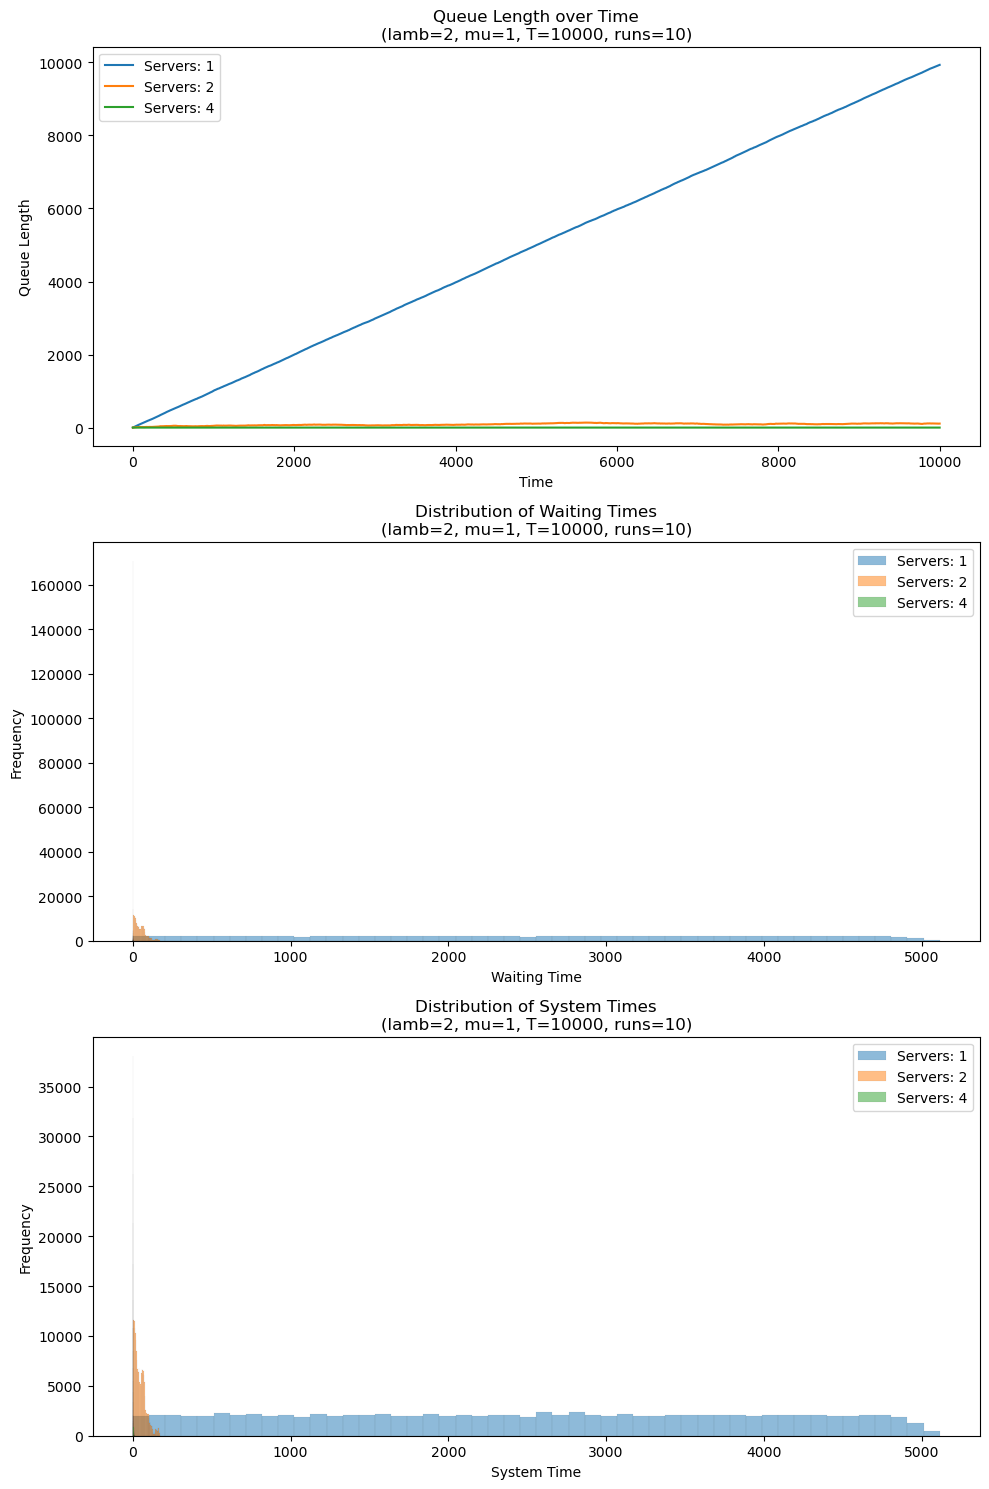

In [139]:
print("Average Queue Lengths:", [f"{length:.2f}" for length in results['avg_queue_length']])
print("Average Waiting Times:", [f"{waiting_time:.2f}" for waiting_time in results['avg_waiting_time']])
print("Average System Times:", [f"{system_time:.2f}" for system_time in results['avg_system_time']])

plot_statistics(results, num_servers_arr, lamb, mu, T, num_runs, edge_color='black')